In [1]:
# https://www.kaggle.com/iafoss/pretrained-resnet34-with-rgby-fast-ai

In [2]:
from old.fastai.conv_learner import *
from old.fastai.dataset import *

import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [3]:
PATH = './'
TRAIN = '../data/train/'
TEST = '../data/test/'
LABELS = '../data/train.csv'

In [4]:
name_label_dict = {
0:  'Nucleoplasm',
1:  'Nuclear membrane',
2:  'Nucleoli',   
3:  'Nucleoli fibrillar center',
4:  'Nuclear speckles',
5:  'Nuclear bodies',
6:  'Endoplasmic reticulum',   
7:  'Golgi apparatus',
8:  'Peroxisomes',
9:  'Endosomes',
10:  'Lysosomes',
11:  'Intermediate filaments',
12:  'Actin filaments',
13:  'Focal adhesion sites',   
14:  'Microtubules',
15:  'Microtubule ends',  
16:  'Cytokinetic bridge',   
17:  'Mitotic spindle',
18:  'Microtubule organizing center',  
19:  'Centrosome',
20:  'Lipid droplets',
21:  'Plasma membrane',   
22:  'Cell junctions', 
23:  'Mitochondria',
24:  'Aggresome',
25:  'Cytosol',
26:  'Cytoplasmic bodies',   
27:  'Rods & rings' }

In [5]:
nw = 2   #number of workers for data loader
arch = resnet34 #specify target architecture

In [6]:
train_names = list({f[:36] for f in os.listdir(TRAIN)})
test_names = list({f[:36] for f in os.listdir(TEST)})
tr_n, val_n = train_test_split(train_names, test_size=0.1, random_state=42)
len(tr_n), len(val_n)

(27964, 3108)

In [7]:
def open_rgby(path,id): #a function that reads RGBY image
#     colors = ['red','green','blue','yellow']
    colors = ['red','green','blue']
    flags = cv2.IMREAD_GRAYSCALE
    img = [cv2.imread(os.path.join(path, id+'_'+color+'.png'), flags).astype(np.float32)/255
           for color in colors]
    return np.stack(img, axis=-1)

In [8]:
class pdFilesDataset(FilesDataset):
    def __init__(self, fnames, path, transform):
        self.labels = pd.read_csv(LABELS).set_index('Id')
        self.labels['Target'] = [[int(i) for i in s.split()] for s in self.labels['Target']]
        super().__init__(fnames, transform, path)
    
    def get_x(self, i):
        img = open_rgby(self.path,self.fnames[i])
        if self.sz == 512: return img 
        else: return cv2.resize(img, (self.sz, self.sz),cv2.INTER_AREA)
    
    def get_y(self, i):
        if(self.path == TEST): return np.zeros(len(name_label_dict),dtype=np.int)
        else:
            labels = self.labels.loc[self.fnames[i]]['Target']
            return np.eye(len(name_label_dict),dtype=np.float)[labels].sum(axis=0)
        
    @property
    def is_multi(self): return True
    @property
    def is_reg(self):return True
    #this flag is set to remove the output sigmoid that allows log(sigmoid) optimization
    #of the numerical stability of the loss function
    
    def get_c(self): return len(name_label_dict) #number of classes

In [9]:
def get_data(sz,bs):
    #data augmentation
    aug_tfms = [RandomRotate(30, tfm_y=TfmType.NO),
                RandomDihedral(tfm_y=TfmType.NO)]
#     stats = A([0.00505, 0.00331, 0.00344, 0.00519], [0.10038, 0.08131, 0.08284, 0.10179])
    stats = A([0.00505, 0.00331, 0.00344], [0.10038, 0.08131, 0.08284])
    tfms = tfms_from_stats(stats, sz, crop_type=CropType.NO, tfm_y=TfmType.NO, 
                aug_tfms=aug_tfms)
    ds = ImageData.get_ds(pdFilesDataset, (tr_n[:-(len(tr_n)%bs)],TRAIN), 
                (val_n,TRAIN), tfms, test=(test_names,TEST))
    md = ImageData(PATH, ds, bs, num_workers=nw, classes=None)
    return md

In [10]:
bs = 16
sz = 256
md = get_data(sz,bs)

x,y = next(iter(md.trn_dl))
x.shape, y.shape

(torch.Size([16, 3, 256, 256]), torch.Size([16, 28]))

In [11]:
# class FocalLoss(nn.Module):
#     def __init__(self, gamma=2):
#         super().__init__()
#         self.gamma = gamma
        
#     def forward(self, input, target):
#         if not (target.size() == input.size()):
#             raise ValueError("Target size ({}) must be the same as input size ({})"
#                              .format(target.size(), input.size()))

#         max_val = (-input).clamp(min=0)
#         loss = input - input * target + max_val + \
#             ((-max_val).exp() + (-input - max_val).exp()).log()

#         invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
#         loss = (invprobs * self.gamma).exp() * loss
        
#         return loss.sum(dim=1).mean()

In [12]:
# https://github.com/kuangliu/pytorch-retinanet/blob/master/loss.py
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F

from utils import one_hot_embedding
from torch.autograd import Variable


class FocalLoss(nn.Module):
    def __init__(self, num_classes=20):
        super(FocalLoss, self).__init__()
        self.num_classes = num_classes

    def focal_loss(self, x, y):
        '''Focal loss.
        Args:
          x: (tensor) sized [N,D].
          y: (tensor) sized [N,].
        Return:
          (tensor) focal loss.
        '''
        alpha = 0.25
        gamma = 2

        t = one_hot_embedding(y.data.cpu(), 1+self.num_classes)  # [N,21]
        t = t[:,1:]  # exclude background
        t = Variable(t).cuda()  # [N,20]

        p = x.sigmoid()
        pt = p*t + (1-p)*(1-t)         # pt = p if t > 0 else 1-p
        w = alpha*t + (1-alpha)*(1-t)  # w = alpha if t > 0 else 1-alpha
        w = w * (1-pt).pow(gamma)
        return F.binary_cross_entropy_with_logits(x, t, w, size_average=False)

    def focal_loss_alt(self, x, y):
        '''Focal loss alternative.
        Args:
          x: (tensor) sized [N,D].
          y: (tensor) sized [N,].
        Return:
          (tensor) focal loss.
        '''
        alpha = 0.25

        t = one_hot_embedding(y.data.cpu(), 1+self.num_classes)
        t = t[:,1:]
        t = Variable(t).cuda()

        xt = x*(2*t-1)  # xt = x if t > 0 else -x
        pt = (2*xt+1).sigmoid()

        w = alpha*t + (1-alpha)*(1-t)
        loss = -w*pt.log() / 2
        return loss.sum()

#     def forward(self, loc_preds, loc_targets, cls_preds, cls_targets):
    def forward(self, loc_preds, loc_targets, cls_preds, cls_targets):
        '''Compute loss between (loc_preds, loc_targets) and (cls_preds, cls_targets).
        Args:
          loc_preds: (tensor) predicted locations, sized [batch_size, #anchors, 4].
          loc_targets: (tensor) encoded target locations, sized [batch_size, #anchors, 4].
          cls_preds: (tensor) predicted class confidences, sized [batch_size, #anchors, #classes].
          cls_targets: (tensor) encoded target labels, sized [batch_size, #anchors].
        loss:
          (tensor) loss = SmoothL1Loss(loc_preds, loc_targets) + FocalLoss(cls_preds, cls_targets).
        '''
        batch_size, num_boxes = cls_targets.size()
        pos = cls_targets > 0  # [N,#anchors]
        num_pos = pos.data.long().sum()

        ################################################################
        # loc_loss = SmoothL1Loss(pos_loc_preds, pos_loc_targets)
        ################################################################
        mask = pos.unsqueeze(2).expand_as(loc_preds)       # [N,#anchors,4]
        masked_loc_preds = loc_preds[mask].view(-1,4)      # [#pos,4]
        masked_loc_targets = loc_targets[mask].view(-1,4)  # [#pos,4]
        loc_loss = F.smooth_l1_loss(masked_loc_preds, masked_loc_targets, size_average=False)

        ################################################################
        # cls_loss = FocalLoss(loc_preds, loc_targets)
        ################################################################
        pos_neg = cls_targets > -1  # exclude ignored anchors
        mask = pos_neg.unsqueeze(2).expand_as(cls_preds)
        masked_cls_preds = cls_preds[mask].view(-1,self.num_classes)
        cls_loss = self.focal_loss(masked_cls_preds, cls_targets[pos_neg])

        print('loc_loss: %.3f | cls_loss: %.3f' % (loc_loss.data[0]/num_pos, cls_loss.data[0]/num_pos), end=' | ')
        loss = (loc_loss+cls_loss)/num_pos
        return loss


In [13]:
def make_one_hot(labels, C=2):
#     print(labels.size(0), labels.size(2))
    one_hot = torch.FloatTensor(labels.size(0), C, labels.size(2)).zero_()
    target = one_hot.scatter_(1, labels.data.type(torch.LongTensor), 1)
    
    target = Variable(target)
        
    return target

class FocalLossMultiLabel(nn.Module):
    def __init__(self, gamma=2., weight=None):
        super().__init__()
        self.gamma = gamma
        self.nll = nn.BCEWithLogitsLoss()
        
    def forward(self, inp, target):
        
#         target = target.type(torch.cuda.LongTensor)
#         target = torch.autograd.Variable(target)
#         print(inp.size(), target.size(), target.squeeze())
        loss = self.nll(inp, target)
#         print(target.size(), target.unsqueeze(dim=1), inp.size()[1])
#         one_hot = make_one_hot(target.unsqueeze(dim=1), inp.size()[1])
        one_hot = make_one_hot(target.unsqueeze(dim=1), inp.size()[0])
        inv_probs = 1 - inp.exp()
#         print(inv_probs.type(), )
        one_hot = one_hot.type(torch.cuda.FloatTensor)
        focal_weights = (inv_probs * one_hot).sum(dim=1) ** self.gamma
        loss = loss * focal_weights
        
        return loss.mean()
    

In [14]:
from sklearn import metrics

import torch
import numpy as np


def f1_score(y_true, y_pred, threshold=0.5):
    return fbeta_score(y_true, y_pred, 2, threshold)


def fbeta_score(y_true, y_pred, beta, threshold, eps=1e-9):
    beta2 = beta**2

#     y_pred = torch.ge(y_pred.float(), threshold).float()
    y_true = y_true.float()
    y_pred = y_pred.float()
#     print(y_true, y_pred)
    
    true_positive = (y_pred * y_true).sum(dim=1)
    precision = true_positive.div(y_pred.sum(dim=1).add(eps))
    recall = true_positive.div(y_true.sum(dim=1).add(eps))

    f1 = (2 * precision*recall).div(precision + recall + eps)
    print(f1)
    return torch.mean(f1)

In [15]:
def dice_coeff(pred, target):
    smooth = 1.
    num = pred.size(0)
    print(num)
    m1 = pred.view(num, -1)  # Flatten
    m2 = target.view(num, -1)  # Flatten
    intersection = (m1 * m2).sum()

    return (2. * intersection + smooth) / (m1.sum() + m2.sum() + smooth)

In [16]:
y_pred = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0],
                   [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
                   [1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1],
                   [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0],
                   [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]])

y_true = np.array([[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0],
                   [1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
                   [1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1],
                   [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
                   [0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]])

py_pred = torch.from_numpy(y_pred)
py_true = torch.from_numpy(y_true)

f1_pytorch = f1_score(py_true, py_pred)
f1_sklearn = metrics.f1_score(y_true, y_pred, average='macro')
dice = dice_coeff(py_pred, py_true)
print('Scores are {:.3f} (sklearn) and {:.3f} (pytorch)'.format(f1_sklearn, f1_pytorch))
print(dice.numpy())

tensor([ 0.8889,  0.7500,  1.0000,  0.8571,  0.8000])
5
Scores are 0.464 (sklearn) and 0.859 (pytorch)
0


/home/watts/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/watts/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [17]:
def acc(preds,targs,thresh=0.0):
    preds = (preds > thresh).int()
    targs = targs.int()
    return (preds==targs).float().mean()

In [18]:
sz = 256 #image size
bs = 64  #batch size

md = get_data(sz,bs)
learner = ConvLearner.pretrained(arch, md, ps=0.5) #dropout 50%
learner.opt_fn = optim.Adam
learner.crit = FocalLossMultiLabel()
learner.metrics = [acc]

In [19]:
learner.summary

<bound method ConvLearner.summary of Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inpla

HBox(children=(IntProgress(value=0, description='Epoch', max=1, style=ProgressStyle(description_width='initial')), HTML(value='')))

  5%|▌         | 22/436 [00:11<03:21,  2.05it/s, loss=8.59]

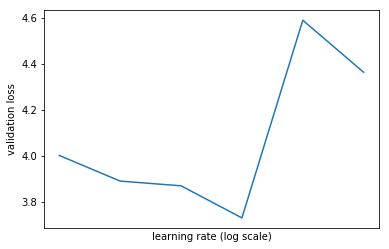

In [20]:
learner.lr_find()
learner.sched.plot()

In [21]:
# import torch

# batch_size = 5
# nb_digits = 10
# # Dummy input that HAS to be 2D for the scatter (you can use view(-1,1) if needed)
# y = torch.LongTensor(batch_size,1).random_() % nb_digits
# # One hot encoding buffer that you create out of the loop and just keep reusing
# y_onehot = torch.FloatTensor(batch_size, nb_digits)

# # In your for loop
# y_onehot.zero_()
# y_onehot.scatter_(1, y, 1)

# print(y)
# print(y_onehot)

In [22]:
lr = 7e-3
learner.fit(lr,1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1, style=ProgressStyle(description_width='initial')), HTML(value='')))

epoch      trn_loss   val_loss   acc                        
    0      2.039476   0.259272   0.941809  


[0.25927200878909196, 0.9418091562263754]

In [23]:
learner.unfreeze()
lrs=np.array([lr/10,lr/3,lr])

In [24]:
learner.fit(lr/5,1,cycle_len=1,use_clr=(10,20))

HBox(children=(IntProgress(value=0, description='Epoch', max=1, style=ProgressStyle(description_width='initial')), HTML(value='')))

epoch      trn_loss   val_loss   acc                          
    0      1.646934   0.222158   0.941418  


[0.2221578872035062, 0.9414184630454123]

In [25]:
learner.fit(lr/5,1,cycle_len=2,use_clr=(10,20))

HBox(children=(IntProgress(value=0, description='Epoch', max=2, style=ProgressStyle(description_width='initial')), HTML(value='')))

epoch      trn_loss   val_loss   acc                         
    0      0.31247    0.195072   0.942073  
    1      0.22785    0.190546   0.942096                    


[0.1905459647703355, 0.9420964371897232]

In [26]:
learner.fit(lr/10,2,cycle_len=4,use_clr=(10,20))

HBox(children=(IntProgress(value=0, description='Epoch', max=8, style=ProgressStyle(description_width='initial')), HTML(value='')))

epoch      trn_loss   val_loss   acc                         
    0      2.553096   0.163844   0.942062  
    1      0.231611   0.163698   0.942096                    
    2      1.008404   0.182347   0.942119                    
    3      0.213522   0.18621    0.942119                    
    4      268.141119 0.194217   0.938442                      
    5      0.552614   0.19498    0.939063                    
    6      0.298057   0.193387   0.93904                     
    7      0.914183   0.195687   0.939752                    


[0.19568742708119646, 0.9397522544001674]

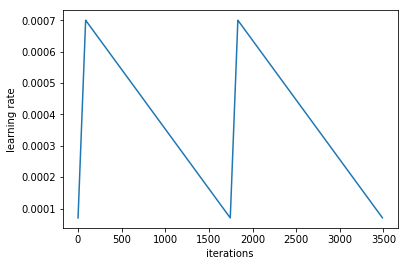

In [27]:
learner.sched.plot_lr()

In [28]:
learner.fit(lr/16,1,cycle_len=8,use_clr=(5,20))

HBox(children=(IntProgress(value=0, description='Epoch', max=8, style=ProgressStyle(description_width='initial')), HTML(value='')))

epoch      trn_loss   val_loss   acc                         
    0      0.203904   0.169074   0.942073  
    1      0.211582   0.171403   0.942085                    
    2      0.185595   0.167109   0.942096                    
    3      0.180534   0.16401    0.942096                    
    4      0.176795   0.164779   0.942108                    
    5      0.173547   0.161929   0.942108                    
    6      0.174953   0.161143   0.942096                    
    7      0.180921   0.165331   0.942096                    


[0.16533054257988777, 0.9420964371897232]

In [29]:
learner.save('ResNet34_256_1')

In [30]:
def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))

preds,y = learner.TTA()
preds = np.stack(preds, axis=-1)
preds = sigmoid_np(preds)
pred = preds.max(axis=-1)

In [72]:
preds_t,y_t = learner.TTA(is_test=True)
preds_t = np.stack(preds_t, axis=-1)
# preds_t = sigmoid_np(preds_t)
# pred_t = preds_t.max(axis=-1)
pred_list = []
for line in pred_t:
    s = ' '.join(list([str(i) for i in np.nonzero(line>0.06)[0]]))
    pred_list.append(s)
df = pd.DataFrame({'Id':learner.data.test_ds.fnames,'Predicted':pred_list})
df.to_csv('../submissions/sub9.csv', header=True, index=False)

KeyboardInterrupt: 

In [57]:
np.max(pred_t)

0.51584405

In [58]:
np.min(pred_t)

4.084526e-11

In [59]:
pred_list[pred_list != '']

''

In [32]:
#https://stackoverflow.com/questions/1855095/how-to-create-a-zip-archive-of-a-directory
def backup_project_as_zip(project_dir, zip_file):
    assert(os.path.isdir(project_dir))
    assert(os.path.isdir(os.path.dirname(zip_file)))
    shutil.make_archive(zip_file.replace('.zip',''), 'zip', project_dir)
    pass

In [33]:
import datetime, shutil
now = datetime.datetime.now()
print(now)
PROJECT_PATH = '/home/watts/lal/Kaggle/kagglehp/scripts_nbs'
backup_project_as_zip(PROJECT_PATH, '../cache/code.scripts_nbs.%s.zip'%now)

2018-10-21 23:28:05.848545


In [70]:
%%time
!kaggle competitions submit -c human-protein-atlas-image-classification -f ../submissions/sub9.csv -m ""

Successfully submitted to Human Protein Atlas Image ClassificationCPU times: user 430 ms, sys: 127 ms, total: 557 ms
Wall time: 18.1 s


In [71]:
from time import sleep
sleep(10)
!kaggle competitions submissions -c human-protein-atlas-image-classification

fileName  date                 description  status    publicScore  privateScore  
--------  -------------------  -----------  --------  -----------  ------------  
sub9.csv  2018-10-21 20:04:09               complete  0.098        None          
sub9.csv  2018-10-21 19:44:17               complete  0.073        None          
sub9.csv  2018-10-21 19:37:30               complete  0.043        None          
sub9.csv  2018-10-21 19:27:51               complete  0.000        None          
sub8.csv  2018-10-20 20:08:45               complete  0.422        None          
sub7.csv  2018-10-20 17:06:09               complete  0.389        None          
sub5.csv  2018-10-19 18:27:33               complete  0.387        None          
sub4.csv  2018-10-19 14:45:15               complete  0.411        None          
sub3.csv  2018-10-19 10:19:26               complete  0.377        None          
sub2.csv  2018-10-19 08:07:30               complete  0.135        None          
sub1.csv  2018-1

In [ ]:
df.head()

In [66]:
pred_t

array([[0.32877, 0.05806, 0.16569, ..., 0.34862, 0.01465, 0.00009],
       [0.33082, 0.05553, 0.16619, ..., 0.33358, 0.01444, 0.00009],
       [0.3042 , 0.05328, 0.16305, ..., 0.31972, 0.01381, 0.00009],
       ...,
       [0.3339 , 0.06438, 0.16627, ..., 0.34009, 0.01633, 0.00011],
       [0.31225, 0.05485, 0.16488, ..., 0.32353, 0.01418, 0.00009],
       [0.43101, 0.0916 , 0.22648, ..., 0.26631, 0.02208, 0.00084]], dtype=float32)

In [64]:
df1 = pd.read_csv('../submissions/sub8.csv')

In [65]:
df1.head()

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,2
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,5 25
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0 5 25
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0 25
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,7 18 25


In [67]:
pred_t[0]

array([0.32877, 0.05806, 0.16569, 0.04894, 0.08478, 0.11755, 0.04795, 0.12675, 0.0003 , 0.00028, 0.00013,
       0.0586 , 0.02459, 0.02356, 0.06116, 0.00051, 0.02247, 0.01616, 0.05165, 0.07193, 0.00364, 0.22084,
       0.01841, 0.18269, 0.00847, 0.34862, 0.01465, 0.00009], dtype=float32)